# Train a Quantized CNN on the PlutoSDR Dataset

This notebook walks through the process of loading the PlutoSDR dataset, declaring a Brevitas CNN model, training said model on the dataset and then exporting it to be used in FINN. The model went through many iterations to find this optimal model design. It is larger than the other models in the repository, meaning it will require a larger FPGA to run on.

# Load the Dataset

The dataset is stored as a series of .npz files in the fullPlutoImport folder. Each file contains iq samples with labels for which channels are occupied for that file. Files are in the form _____ with ___ being the negative number of decabels the signals are bradcast at and __ being which channels are occupied.

To reduce training times this function can be used to reduce the amount of files being used.

In [1]:
def filter_strings(lst):
    filtered_list = [s for s in lst if not any(digit in s for digit in "3456789")]
    return filtered_list

factor is used to decide the buffer size being used with the buffer size being factor*128. This loops through each of the files and seperates the samples into lists each of the buffer length. The iq samples are kept seperate in one dimension and the buffer is equaly spread accross two dimensions, e.g. a buffer of 256 would have a shape of 2,16,16. The origninal data values are between 2 and -2, however the expected input will be an 8 bit integer so the values are normalised to between 127 and -128. Finally the data is split up into traing, test and validation data and put into dataloaders.

In [2]:
import numpy as np
import os as os
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math

folder = "../fullPlutoImport"
files = os.listdir(folder)

filtered_files = filter_strings(files)

factor = 2
noFiles = len(filtered_files)

arr = np.ndarray((int(7800*noFiles/factor),2,int(math.sqrt(factor*128)),int(math.sqrt(factor*128))), float)
labels = np.ndarray((int(7800*noFiles/factor),4))

seed = 0

i = 0;
for idx, npz in enumerate(filtered_files):
    
    a = np.load(os.path.join(folder, npz))
    
    start_idx = (idx*int(7800/factor)) if idx <20 else (idx)*int(7800/factor)-1
    end_idx = (1+idx)*int(7800/factor) if idx <20 else (1+idx)*int(7800/factor)-1
    
    # print(f"start index: {start_idx}, end index {end_idx}, activate channels: {a['active_channels']}")
       
    reshaped_arr = a["samples"].reshape(int(7800/factor),int(math.sqrt(factor*128)),int(math.sqrt(factor*128)))
    
    float_array = np.stack((reshaped_arr.real, reshaped_arr.imag), axis=1) 

    arr[start_idx:end_idx] = float_array
    labels[start_idx:end_idx] = np.tile(a["active_channels"],  (int(7800/factor), 1))

    i+=1
    if i >= noFiles:
        break
    
normalized_array = 255 * (arr + 2) / (4) - 128

# first split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(normalized_array, labels, test_size=0.2, random_state=seed)

# then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=seed)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.int8), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.int8), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.int8), torch.tensor(y_val, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

A subset of the data is used for testing on the PYNQ-Z2. That is loaded in here so that the accuracy in hardware can be compared.

In [3]:
folder = "../data"
files = os.listdir(folder)

noFiles = len(files)

arr = np.ndarray((int(7800*noFiles/factor),2,int(math.sqrt(factor*128)),int(math.sqrt(factor*128))), float)
labels = np.ndarray((int(7800*noFiles/factor),4))

seed = 0

i = 0;
for idx, npz in enumerate(files):
    
    a = np.load(os.path.join(folder, npz))
    
    start_idx = (idx*int(7800/factor)) if idx <20 else (idx)*int(7800/factor)-1
    end_idx = (1+idx)*int(7800/factor) if idx <20 else (1+idx)*int(7800/factor)-1
    
    # print(f"start index: {start_idx}, end index {end_idx}, activate channels: {a['active_channels']}")
       
    reshaped_arr = a["samples"].reshape(int(7800/factor),int(math.sqrt(factor*128)),int(math.sqrt(factor*128)))
    
    float_array = np.stack((reshaped_arr.real, reshaped_arr.imag), axis=1) 

    arr[start_idx:end_idx] = float_array
    labels[start_idx:end_idx] = np.tile(a["active_channels"],  (int(7800/factor), 1))

    i+=1
    if i >= noFiles:
        break
    
normalized_array = 255 * (arr + 2) / (4) - 128

onboard_dataset = TensorDataset(torch.tensor(normalized_array, dtype=torch.int8), torch.tensor(labels, dtype=torch.float32))
onboard_loader = DataLoader(onboard_dataset, batch_size=256, shuffle=True)


# Define a PyTorch Device <a id='define_pytorch_device'></a> 

GPUs can significantly speed-up training of deep neural networks. We check for availability of a GPU and if so define it as target device.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cuda


# Define the Quantized CNN Model</a>


Variables to control the size of the model.

In [5]:
input_bits = 4
a_bits = 4
w_bits = 4
filters_conv = 32
filters_dense = 64

The model is defined using a variety of Brevitas and PyTorch classes. Since the linear, conv, hardtanh and ReLU functions are defined with Brevitas classes this means that all of the weights and activations are quantized to the previously specified values. The dropout and batchnormalization layers are from PyTorch as they cannot be quantized. Testing showed this to be an optimal model design for the problem

In [6]:


from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

filters_conv = 32
filters_dense = 128
input_size = 16

output_size = input_size//4 * input_size//4 *filters_conv

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    bit_width = input_bits
    min_val = -2.0
    max_val = 2.0
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]


model = nn.Sequential(
    # Input quantization layer
    qnn.QuantHardTanh(act_quant=InputQuantizer),

    qnn.QuantConv2d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm2d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    # nn.MaxPool2d(2),

    qnn.QuantConv2d(filters_conv, filters_conv*2, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm2d(filters_conv*2),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool2d(2),

     qnn.QuantConv2d(filters_conv*2, filters_conv*2, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm2d(filters_conv*2),
    qnn.QuantReLU(bit_width=a_bits),
    # nn.MaxPool2d(2),

    qnn.QuantConv2d(filters_conv*2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm2d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool2d(2),

    nn.Flatten(),

    qnn.QuantLinear(output_size, 4, weight_bit_width=w_bits, bias=False),
)


model.to(device)

Sequential(
  (0): QuantHardTanh(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
            (input_view_impl): Identity()
          )
          (scaling_impl): ConstScaling(
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_init_module): Identity()
            (value): StatelessBuffer()
          )
          (int_scaling_impl): IntScaling()
      

# Define Train and Test  Methods
The train and test methods are declared, QAT is automatically completed by Brevitas. This results in them being very similar to standard PyTorch training and testing methods. The outputs are put through a sigmoid then compared to 0.5 to convert them to binary for accuracy measurement.

In [7]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.cpu().numpy()) 
           
    return losses

import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            output_orig = model(inputs.float())
            # run the output through sigmoid
            output = torch.sigmoid(output_orig)  
            # compare against a threshold of 0.5 to generate 0/1
            pred = (output.detach().cpu().numpy() > 0.5) * 1
            target = target.cpu().float()
            y_true.extend(target.flatten().tolist()) 
            y_pred.extend(pred.flatten().tolist())
        
    return accuracy_score(y_true, y_pred)

# Train the QNN <a id="train_qnn"></a>


## Train the Model from Scratch

In [8]:
num_epochs = 10

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [9]:
# loss criterion and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss().to(device)

import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, train_loader, optimizer,criterion)
        test_acc = test(model, test_loader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)


Training loss:   0%|          | 0/10 [00:00<?, ?it/s]/home/dspedia/.local/lib/python3.10/site-packages/torch/_tensor.py:1488: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1928.)
  return super().rename(names)
/home/dspedia/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:549: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:311.)
  return F.conv2d(
Training loss = 0.213250 test accuracy = 0.873847: 100%|██████████| 10/10 [04:23<00:00, 26.39s/it]


In [10]:
test_acc = test(model, onboard_loader)
test_acc

0.8574708624708625

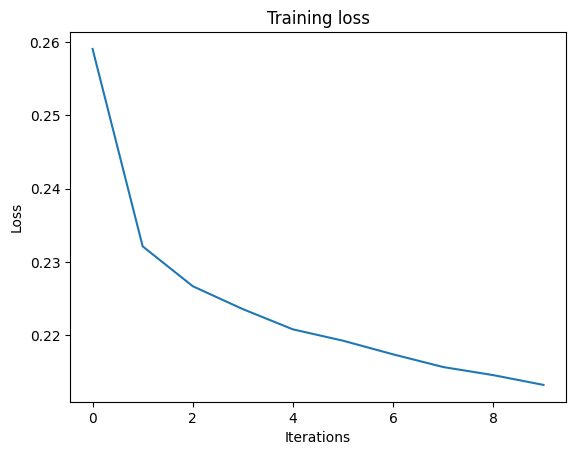

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

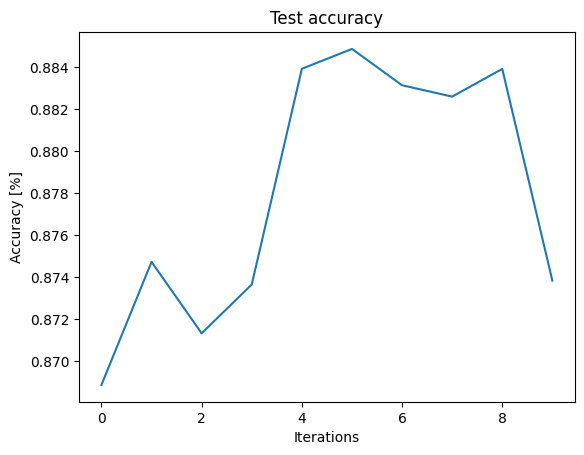

In [12]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

The model is saved for software verification

In [13]:
# Save the Brevitas model to disk
torch.save(model.state_dict(), "state_dict_self-trained.pth")

# Output Quantization

Depending on the requirements of the cognitive radio it can be better to have the model output a zero or one depending on whether the model beleives that channel is occupied. This is also more convenient for verifying the model with the deployment package.

In [14]:
# Move the model to CPU before surgery
model = model.cpu()

This wrapper class quantizes the output down to 1 bit. Brevitas uses the bipolar data type to represent this output.

In [15]:
from brevitas.nn import QuantIdentity

class BipolarForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(BipolarForExport, self).__init__()
        self.pretrained = my_pretrained_model
        self.qnt_output = QuantIdentity(
            quant_type='binary', 
            scaling_impl_type='const',
            bit_width=1, min_val=-1.0, max_val=1.0)
    
    def forward(self, x):
        out_original = self.pretrained(x)
        out_final = self.qnt_output(out_original)   # output as {-1,1}     
        return out_final



model_for_export = BipolarForExport(model)
model_for_export.to(device)

BipolarForExport(
  (pretrained): Sequential(
    (0): QuantHardTanh(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
              (input_view_impl): Identity()
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (clamp_min_ste): Identity()
                (restrict_value_impl): FloatRestrictValue()
              )
              (restrict_init_module): Identity()
              (value

In [16]:
test(model_for_export, test_loader)

0.8738336894586894

# Export to QONNX and Conversion to FINN-ONNX

Breivtas provides functionality to export models to qonnx, the only additional information is the input data shape.

FINN then needs to take the qonnx output and translate it to its "dialect" for it to be used with the FINN build_dataflow tool.

This is repeated twice: once with the quantized output and once without.

In [17]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

ready_model_filename = "cnn_ready_qout.onnx"
input_shape = (1, 2,int(math.sqrt(factor*128)),int(math.sqrt(factor*128)))

# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
input_t = torch.from_numpy(input_a)

#Move to CPU before export
model_for_export.cpu()

# Export to ONNX
export_qonnx(
    model_for_export, export_path=ready_model_filename, input_t=input_t
)

# clean-up
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)

outmodel = ModelWrapper(ready_model_filename)
# Setting the input datatype explicitly because it doesn't get derived from the export function
outmodel.set_tensor_datatype(outmodel.graph.input[0].name, DataType["INT8"])

outmodel = outmodel.transform(ConvertQONNXtoFINN())
outmodel.save(ready_model_filename)

print("Model saved to %s" % ready_model_filename)


ready_model_filename = "cnn_ready.onnx"
model_for_export = model

#Move to CPU before export
model_for_export.cpu()

# Export to ONNX
export_qonnx(
    model_for_export, export_path=ready_model_filename, input_t=input_t
)

# clean-up
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)

outmodel = ModelWrapper(ready_model_filename)
# Setting the input datatype explicitly because it doesn't get derived from the export function
outmodel.set_tensor_datatype(outmodel.graph.input[0].name, DataType["INT8"])

outmodel = outmodel.transform(ConvertQONNXtoFINN())
outmodel.save(ready_model_filename)

print("Model saved to %s" % ready_model_filename)

Model saved to cnn_ready_qout.onnx
Model saved to cnn_ready.onnx


## View the Exported ONNX in Netron

In [18]:
from finn.util.visualization import showInNetron

showInNetron("cnn_ready_qout.onnx")

Serving 'cnn_ready_qout.onnx' at http://0.0.0.0:8081
